# Metric Learning with ArcFace loss function
test run on cpu

参考：
- PyTorch Metric Learning: https://kevinmusgrave.github.io/pytorch-metric-learning/losses/#arcfaceloss
- Arcfaceお試し(pytorch metric learning): https://note.com/pollenallergy/n/ne627d7d45876

In [120]:
import os
import time

from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import albumentations as A
import torch
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import timm
from pytorch_metric_learning import losses

import umap
import seaborn as sns

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Data

In [5]:
!ls ../tmp/market_metriclearning_HT

images    test.csv  train.csv


In [6]:
!ls -l ../tmp/market_metriclearning_HT/images | wc -l

   12937


In [7]:
image_dir = '../tmp/market_metriclearning_HT/images'

In [83]:
df_train = pd.read_csv('../tmp/market_metriclearning_HT/train.csv')
print(df_train.shape)
df_train.head()

(12114, 3)


,image_id,label,fold
0,0517_c5s1_143520_02.jpg,517,2
1,0816_c6s2_104418_01.jpg,816,4
2,1278_c1s6_012016_02.jpg,1278,2
3,0508_c5s2_082302_02.jpg,508,1
4,1198_c6s3_034292_01.jpg,1198,3


In [84]:
# test run用少量データ
test_idx = 0
test_classes = 10
df_train = df_train[df_train['label'].isin(df_train['label'].value_counts()[test_idx:(test_idx+test_classes)].index)]

df_train.shape

(577, 3)

In [85]:
df_train['label'].value_counts()

label
299    74
139    66
105    61
197    59
272    59
208    58
22     53
132    49
148    49
261    49
Name: count, dtype: int64

In [138]:
df_train['label'].nunique(), df_train['label'].min(), df_train['label'].max()

(10, 22, 299)

In [88]:
# pytorch学習用ラベルの作成
labels = df_train['label'].unique()
labels.sort()
id_label = {v:i for i,v in enumerate(labels)}
df_train['label_id'] = df_train['label'].map(id_label)   # label_idをtargetに利用

In [89]:
df_train

,image_id,label,fold,label_id
5,0022_c4s1_004376_03.jpg,22,2,0
10,0132_c6s1_022726_01.jpg,132,1,2
17,0197_c2s1_038751_03.jpg,197,0,5
20,0272_c6s1_057426_01.jpg,272,1,8
26,0272_c5s1_066298_01.jpg,272,0,8
...,...,...,...,...
12064,0299_c5s1_067148_02.jpg,299,3,9
12070,0197_c5s1_045301_05.jpg,197,4,5
12080,0299_c5s1_092623_01.jpg,299,1,9
12085,0197_c5s1_045151_05.jpg,197,2,5


In [90]:
df_train['label_id'].min(), df_train['label_id'].max()

(0, 9)

In [92]:
df_test = pd.read_csv('../tmp/market_metriclearning_HT/test.csv')
print(df_test.shape)
df_test.head()

(1356, 2)


,image_id,label
0,0655_c5s2_037230_03.jpg,655
1,0806_c6s2_088893_10.jpg,806
2,1106_c2s2_147252_01.jpg,1106
3,1422_c3s3_057028_06.jpg,1422
4,0309_c3s1_074117_01.jpg,309


## Metric Learningの実施

In [140]:
img_size = 128
batch_size = 64
init_learning_rate = 0.0001    # 学習率（初期）

dataframe_image_col = 'image_id'
dataframe_label_col = 'label_id'

embedding_dim = 256    # 距離学習のEmbedding次元数
class_size = df_train[dataframe_label_col].nunique()    # 学習データのラベルのクラス数
print(f'class_size: {class_size}')

class_size: 10


### Augmentation, Dataset

In [94]:
transform_scoring = A.Compose([
    A.Resize(height=img_size, width=img_size, p=1),
])

In [95]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, df, img_dir, transforms, mode='train'):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transforms = transforms
        self.mode = mode

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        img_file_name = self.df.loc[index, dataframe_image_col]
        img_file_path = os.path.join(self.img_dir, img_file_name)
        target = self.df.loc[index, dataframe_label_col]
    
        image = cv2.imread(img_file_path)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        image_transformed = self.transforms(image=image)['image']

        image_transformed = image_transformed.astype(np.float32)
        image_transformed = image_transformed.transpose(2, 0, 1)
        image_transformed /= 255.

        if self.mode == 'inference':
            return torch.tensor(image_transformed).float()
        else:   # Train/Valid/Testなど正解ラベルが必要な時
            return torch.tensor(image_transformed).float(), torch.tensor(target).long()

<__main__.CustomDataset object at 0x7f7baae3fd90> 577
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([3, 128, 128]) tensor(6)


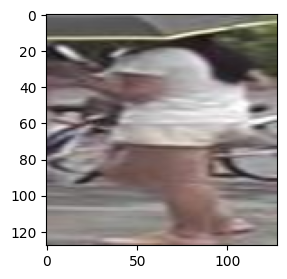

In [96]:
# Dataset test
tmp_dataset = CustomDataset(df=df_train, img_dir=image_dir, transforms=transform_scoring, mode='train')
print(tmp_dataset, len(tmp_dataset))

tmp_img, tmp_label = tmp_dataset[10]    # 表示画像indexを指定
print(type(tmp_img), type(tmp_label))
print(tmp_img.shape, tmp_label)

plt.figure(figsize=[3,3])
plt.imshow(tmp_img.permute(1, 2, 0))
plt.show()

### Model

In [97]:
# モデルアウトプットのクラス数を、距離学習のEmbedding次元数に設定
backborn = timm.create_model('resnet18', pretrained=True, num_classes=embedding_dim)
backborn.default_cfg

{'url': 'https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet18_a1_0-d63eafa0.pth',
 'hf_hub_id': 'timm/resnet18.a1_in1k',
 'architecture': 'resnet18',
 'tag': 'a1_in1k',
 'custom_load': False,
 'input_size': (3, 224, 224),
 'test_input_size': (3, 288, 288),
 'fixed_input_size': False,
 'interpolation': 'bicubic',
 'crop_pct': 0.95,
 'test_crop_pct': 1.0,
 'crop_mode': 'center',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'num_classes': 1000,
 'pool_size': (7, 7),
 'first_conv': 'conv1',
 'classifier': 'fc',
 'origin_url': 'https://github.com/huggingface/pytorch-image-models',
 'paper_ids': 'arXiv:2110.00476'}

In [98]:
backborn.fc

Linear(in_features=512, out_features=256, bias=True)

In [99]:
# output test
# Embedding次元数が出力
backborn(torch.rand(8, 3, 328, 328)).shape

torch.Size([8, 256])

### 学習
mAPといった指標でよく精度評価が実施されたりするが実装が不明なため実施なし

In [100]:
def train_func(model, train_loader, criterion, optimizer):
    losses = []
    bar = tqdm(train_loader)
    model.train()

    for i, (images, targets) in enumerate(bar):    # バッチループ
        images = images.to(device)
        targets = targets.to(device)
        outputs = model(images)
        #criterion = criterion.to(device)
        loss = criterion(outputs, targets)
        #print(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        smooth_loss = np.mean(losses[-5:])   # 過去5バッチループのLoss平均

        bar.set_description(f'loss: {loss.item():.5f}, smth: {smooth_loss:.5f}')

    loss_train= np.mean(losses)
    return loss_train

def valid_func(model, valid_loader, criterion): 
    losses = []
    OUTPUTS, TARGETS = [], []
    bar = tqdm(valid_loader)
    model.eval()

    with torch.no_grad():
        for i, (images, targets) in enumerate(bar):    # バッチループ
            images = images.to(device)
            targets = targets.to(device)
            outputs = model(images)
            criterion = criterion.to(device)
            loss = criterion(outputs, targets)

            losses.append(loss.item())
            smooth_loss = np.mean(losses[-5:])

            bar.set_description(f'loss: {loss.item():.5f}, smth: {smooth_loss:.5f}')

            OUTPUTS.append(outputs.cpu())
            TARGETS.append(targets.cpu())

        loss_valid = np.mean(losses)
        
        ''' to do:  mAPの実装
        PREDS = f(OUTPUTS)
        map = mAP(TARGETS, PREDS))
        '''

    return loss_valid
    #return loss_valid, map

In [101]:
#metric = losses.ArcFaceLoss(num_classes=class_size, embedding_size=embedding_dim, scale=10, margin=0.5)
#metric

In [102]:
def run(fold):
    print('Running fold #{}'.format(fold))

    train_ = df_train[df_train['fold']!=fold]
    #train_ = df_train
    valid_ = df_train[df_train['fold']==fold]
    print(df_train.shape, train_.shape, valid_.shape)

    dataset_train = CustomDataset(df=train_, img_dir=image_dir, transforms=transform_scoring , mode='train')
    dataset_valid = CustomDataset(df=valid_, img_dir=image_dir, transforms=transform_scoring, mode='train')

    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)#, num_workers=2)
    valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)#, num_workers=2)

    print(f'Batch size: {batch_size}')
    print('train samples:', len(dataset_train), 'valid samples:', len(dataset_valid))
    print('train batch roops:', len(train_loader), 'valid batch roops:', len(valid_loader))

    model = m.to(device)
    #print(model)
    metric = losses.ArcFaceLoss(num_classes=class_size, embedding_size=embedding_dim, scale=10, margin=0.5)
    #print(metric)
    optimizer = optim.Adam([{'params': model.parameters()}, {'params': metric.parameters()}], lr=init_learning_rate)
    #print(optimizer)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs-1, eta_min=1e-8)
    #print(scheduler)

    log = {}
    log_file = f'{exp_name}_fold{fold}_log.txt'
    model_file = os.path.join('tmp', f'{exp_name}_fold{fold}_best.pth')
    best_map = 0.0

    for epoch in range(n_epochs):
        print('>> Epoch: {}/{}'.format(epoch+1, n_epochs))

        loss_train = train_func(model, train_loader, metric, optimizer)
        print('Training:: Loss: {}'.format(loss_train))
        
        ''' to do
        loss_valid, map = valid_func(model, valid_loader, metric)
        print('Validation:: Loss: {}, mAP: {}'.format(loss_valid, map))
        '''
        loss_valid = valid_func(model, valid_loader, metric)
        print('Validation:: Loss: {}'.format(loss_valid))

        log['loss_train'] = log.get('loss_train', []) + [loss_train]
        log['loss_valid'] = log.get('loss_valid', []) + [loss_valid]
        log['lr'] = log.get('lr', []) + [optimizer.param_groups[0]["lr"]]
        ''' to do
        log['mAP'] = log.get('acc', []) + [map]
        '''

        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, loss_train: {loss_train:.5f}, loss_valid: {loss_valid:.5f}.'
        ''' to do
        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, loss_train: {loss_train:.5f}, loss_valid: {loss_valid:.5f}, acc: {acc:.4f}.'
        '''
        print(content)
        with open(log_file, 'a') as fp:
            fp.write(content + '\n')

        ''' to do
        if acc > best_map:
            print(f'best_map ({best_map:.6f} --> {map:.6f}). Saving model ...')
            map_max = map
            torch.save(model.state_dict(), model_file)
        '''

        scheduler.step(epoch+1)

    torch.save(model.state_dict(), model_file.replace('_best', '_final'))
    return log

In [104]:
# Test run
n_epochs = 5

m = backborn

fold = 0
exp_name = 'TestExperiment'

tmp_log = run(fold=fold)
tmp_log

Running fold #0
(577, 4) (478, 4) (99, 4)
Batch size: 64
train samples: 478 valid samples: 99
train batch roops: 8 valid batch roops: 2
>> Epoch: 1/5


  0%|          | 0/8 [00:00<?, ?it/s]

Training:: Loss: 2.3553719222545624


  0%|          | 0/2 [00:00<?, ?it/s]

Validation:: Loss: 2.2378714084625244
Sun Apr 21 09:47:55 2024 Fold 0, Epoch 0, lr: 0.0001000, loss_train: 2.35537, loss_valid: 2.23787.
>> Epoch: 2/5


/opt/anaconda3/envs/PyTorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/8 [00:00<?, ?it/s]

Training:: Loss: 1.9141699224710464


  0%|          | 0/2 [00:00<?, ?it/s]

Validation:: Loss: 2.053238570690155
Sun Apr 21 09:48:20 2024 Fold 0, Epoch 1, lr: 0.0000854, loss_train: 1.91417, loss_valid: 2.05324.
>> Epoch: 3/5


  0%|          | 0/8 [00:00<?, ?it/s]

Training:: Loss: 1.6597112119197845


  0%|          | 0/2 [00:00<?, ?it/s]

Validation:: Loss: 1.8801220655441284
Sun Apr 21 09:48:45 2024 Fold 0, Epoch 2, lr: 0.0000500, loss_train: 1.65971, loss_valid: 1.88012.
>> Epoch: 4/5


  0%|          | 0/8 [00:00<?, ?it/s]

Training:: Loss: 1.5193759053945541


  0%|          | 0/2 [00:00<?, ?it/s]

Validation:: Loss: 1.8366379141807556
Sun Apr 21 09:49:11 2024 Fold 0, Epoch 3, lr: 0.0000147, loss_train: 1.51938, loss_valid: 1.83664.
>> Epoch: 5/5


  0%|          | 0/8 [00:00<?, ?it/s]

Training:: Loss: 1.4703827649354935


  0%|          | 0/2 [00:00<?, ?it/s]

Validation:: Loss: 1.790976881980896
Sun Apr 21 09:49:36 2024 Fold 0, Epoch 4, lr: 0.0000000, loss_train: 1.47038, loss_valid: 1.79098.


{'loss_train': [2.3553719222545624,
  1.9141699224710464,
  1.6597112119197845,
  1.5193759053945541,
  1.4703827649354935],
 'loss_valid': [2.2378714084625244,
  2.053238570690155,
  1.8801220655441284,
  1.8366379141807556,
  1.790976881980896],
 'lr': [0.0001,
  8.535680352542144e-05,
  5.0005000000000007e-05,
  1.465319647457856e-05,
  1e-08]}

## 推論（Embeddingの出力）

In [141]:
# 学習データに対する推論を実施
print(df_train.shape)
dataset_test = CustomDataset(df=df_train, img_dir=image_dir, transforms=transform_scoring, mode='train')
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

(577, 4)


In [106]:
OUTPUTS, TARGETS = [], []
bar = tqdm(test_loader)
m = m.to(device)
m.eval()

with torch.no_grad():
        for i, (images, targets) in enumerate(bar):    # バッチループ
            images = images.to(device)
            targets = targets.to(device)
            outputs = m(images)
            
            OUTPUTS.append(outputs.cpu().numpy())
            TARGETS.append(targets.cpu().numpy())

OUTPUTS = np.concatenate(OUTPUTS)
TARGETS = np.concatenate(TARGETS)

  0%|          | 0/10 [00:00<?, ?it/s]

In [107]:
OUTPUTS.shape, TARGETS.shape

((577, 256), (577,))

In [108]:
OUTPUTS[0][:50]

array([-0.30972913,  0.24894972,  0.11193155,  0.13857576, -0.48957723,
       -0.11820778,  0.39553946, -0.11926966, -0.21365085, -0.00060529,
        0.35128397, -0.357658  ,  0.04310461,  0.16532364, -0.04231553,
       -0.39988047,  0.01640154,  0.22465196, -0.07234795,  0.254635  ,
       -0.2510941 , -0.04035462, -0.09429121,  0.0840448 ,  0.2328607 ,
       -0.06234705,  0.13906801,  0.08587312,  0.17869294,  0.06025479,
       -0.03848144, -0.06839095, -0.21597445, -0.002413  ,  0.09445474,
       -0.5605424 ,  0.30935955, -0.35569263,  0.38423344, -0.16529468,
        0.08120942, -0.09865782,  0.5166185 , -0.1139985 ,  0.1371681 ,
        0.02819632,  0.12038049,  0.12073813,  0.03437841,  0.40479207],
      dtype=float32)

In [109]:
TARGETS.min(), TARGETS.max(), pd.Series(TARGETS).nunique()

(0, 9, 10)

## 可視化（UMAP）

/opt/anaconda3/envs/PyTorch/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/50/glkvvhjx03g22fwy2r0tgylr0000gn/T/ipykernel_88928/87445950.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[:, 0], embedding[:, 1],


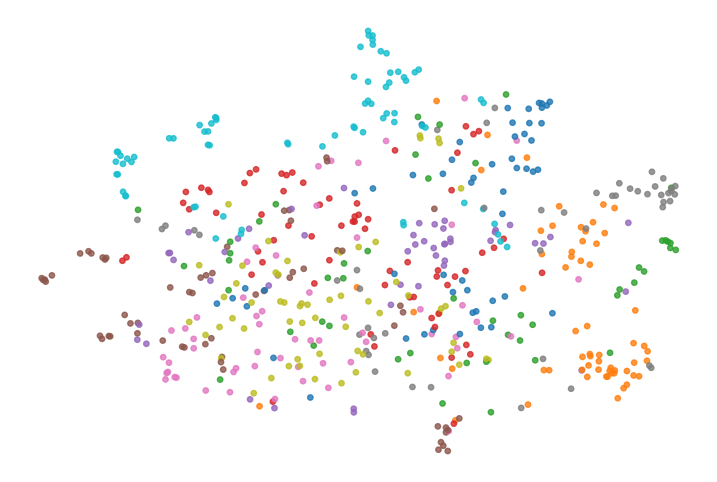

In [137]:
mapper = umap.UMAP(random_state=0)
embedding = mapper.fit_transform(OUTPUTS)

import matplotlib.pyplot as plt 
plt.figure(figsize=(9, 6))
plt.scatter(embedding[:, 0], embedding[:, 1],
            c=[sns.color_palette()[x] for x in TARGETS], 
            #c=TARGETS,
            cmap='Spectral',
            s=15, 
            alpha=0.8)
plt.axis('off')
#plt.colorbar()
plt.show()

## todo: 類似画像の取得
ある画像を指定し、類似したtop kを表示